# Sentiment Analysis of Reddit Data

This project aims to perform sentiment analysis on Reddit data using various natural language processing (NLP) models. The primary objectives are to:

- **Data Collection**: Gather posts and comments from the Python subreddit using the Reddit API.
- **Data Cleaning**: Preprocess the text data to remove noise, including URLs, special characters, and unnecessary whitespace.
- **Sentiment Analysis**: Utilize multiple sentiment analysis models, including TextBlob, VADER, and a transformer-based model (DistilBERT), to evaluate the sentiment of the collected data.
- **Feature Engineering**: Implement additional features such as TF-IDF vectorization to enhance model performance.
- **Model Evaluation**: Assess and compare the performance of each model using metrics such as accuracy, precision, recall, and F1-score, along with visualizations like confusion matrices and box plots.
- **Comparative Analysis**: Analyze the results to determine which sentiment analysis model performs best for the given dataset.

This project serves as a comprehensive exploration of sentiment analysis techniques and their effectiveness in understanding public sentiment expressed in online discussions.

In [1]:
# Gather Reddit data
import praw
import os
from dotenv import load_dotenv

# Load the environment variables from the .env file
load_dotenv()

# Access the variables
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')
user_agent = os.getenv('USER_AGENT')

# Initalize the Reddit API client
reddit = praw.Reddit(client_id = client_id, 
                     client_secret = client_secret,
                    user_agent = user_agent)

# Choose a subreddit and fetch the posts
subreddit = reddit.subreddit('python')
posts = subreddit.hot(limit=100)

# Collect the post titles and comments
data = []
for post in posts:
    data.append(post.title)
    post.comments.replace_more(limit=0)
    for comment in post.comments.list():
        data.append(comment.body)

In [2]:
# Data Cleaning
import re

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text.strip()

cleaned_data = [clean_text(text) for text in data]

In [3]:
# Perform sentiment analysis with TextBlob
from textblob import TextBlob

def textblob_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

textblob_results = [textblob_sentiment(text) for text in cleaned_data]

In [4]:
# Perform sentiment analysis with VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader_analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    return vader_analyzer.polarity_scores(text)['compound']

vader_results = [vader_sentiment(text) for text in cleaned_data]

In [5]:
# Perform sentiment analysis with Transformers
from transformers import pipeline, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
transformer_analyzer = pipeline('sentiment-analysis', model=model_name)

def analyze_sentiment(text):
    tokens = transformer_analyzer.tokenizer.encode(text, truncation=True, max_length=510)
    truncated_text = transformer_analyzer.tokenizer.decode(tokens)
    result = transformer_analyzer(truncated_text)
    return result[0]['score']

transformer_results = [analyze_sentiment(text) for text in cleaned_data]

2024-08-22 16:02:10.190212: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-22 16:02:10.197247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 16:02:10.206799: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 16:02:10.209590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 16:02:10.218182: I tensorflow/core/platform/cpu_feature_guar

In [6]:
# Feature Engineering with TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(cleaned_data)

In [7]:
# Evaluation and Validation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

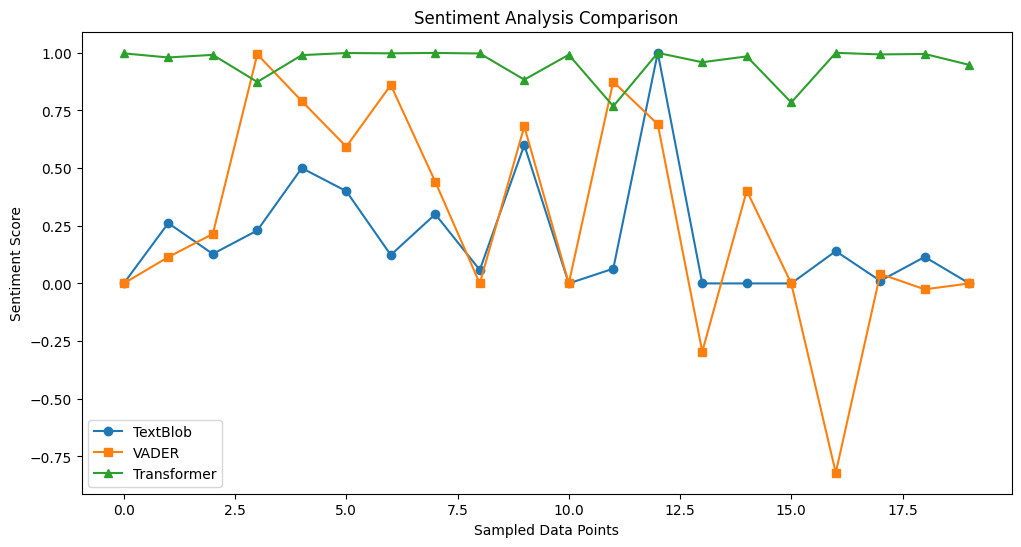

In [8]:
# Comparative Analysis
import random
import matplotlib.pyplot as plt

sample_size = 20
indices = random.sample(range(len(cleaned_data)), sample_size)

plt.figure(figsize=(12, 6))
plt.plot([textblob_results[i] for i in indices], label='TextBlob', marker='o')
plt.plot([vader_results[i] for i in indices], label='VADER', marker='s')
plt.plot([transformer_results[i] for i in indices], label='Transformer', marker='^')
plt.legend()
plt.title('Sentiment Analysis Comparison')
plt.xlabel('Sampled Data Points')
plt.ylabel('Sentiment Score')
plt.show()

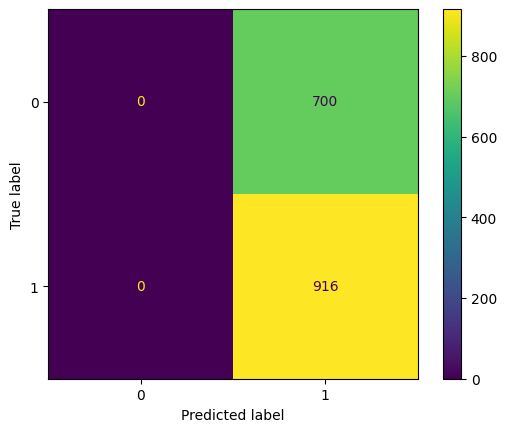

In [9]:
# Confusion Matrix Example
predictions = [1 if score > 0 else 0 for score in transformer_results]  # Example threshold
true_labels = [1 if score > 0 else 0 for score in textblob_results]  # Using TextBlob as a reference for demonstration

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

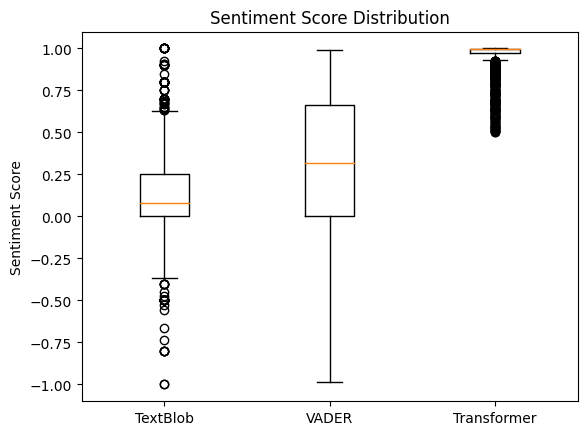

In [10]:
# Box Plot for Sentiment Scores
plt.boxplot([textblob_results, vader_results, transformer_results], 
            labels=['TextBlob', 'VADER', 'Transformer'])
plt.title('Sentiment Score Distribution')
plt.ylabel('Sentiment Score')
plt.show()